# SESSION NORMALE DEEP LEARNING

### DESCRIPTION ET OBJECTIF : Ce jeu données contient les images pour détecter l’analyse de la maladie rénale(Stone, Tumor). Donc nous devons à partir de ces données faire des prédictions à partir d'un modèle classique CNN et d'un modele pre-entrainé 

In [1]:
#importation des libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import splitfolders
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,BatchNormalization,Flatten,Dense,Dropout,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

In [2]:
#repertoires des images
data_dir = 'dataset'

# Division des données en données d'entraînement et de test en utilisant un pourcentage de 20% pour les données de test
splitfolders.ratio(data_dir, output="dataset_CT_kidney", seed=19223)

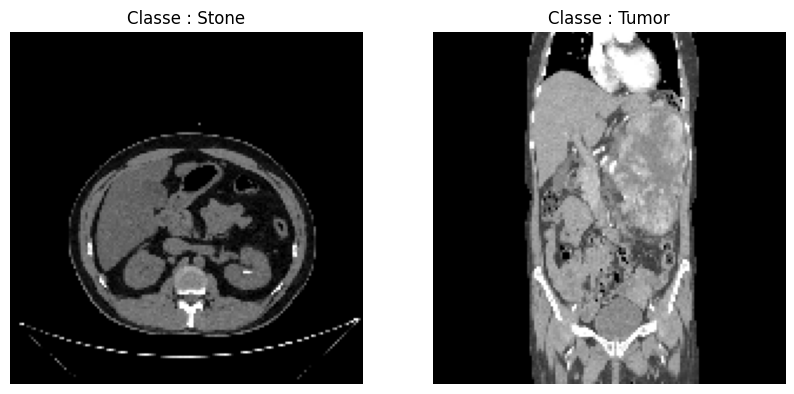

In [3]:
import os
import random
from tensorflow.keras.preprocessing import image

# Vérification visuelle
classes = ['Stone', 'Tumor'] # Tes vraies classes
plt.figure(figsize=(10, 5))

for i, class_name in enumerate(classes):
    folder = f"dataset_CT_kidney/train/{class_name}"
    # On prend une image au hasard
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    
    img = image.load_img(img_path, target_size=(150, 150))
    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Classe : {class_name}")
    plt.axis('off')
plt.show()

In [4]:
#generation des images pour augmenter la taille du dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range = 40,width_shift_range = 0.2,
                                      height_shift_range = 0.2,shear_range = 0.2,
                                      zoom_range = 0.2,horizontal_flip = True,
                                      rescale = 1./255,fill_mode = 'nearest')
val_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
training_set = train_datagen.flow_from_directory("dataset_CT_kidney/train",target_size=(150,150),batch_size=32, class_mode="binary")

Found 3511 images belonging to 2 classes.


In [6]:
validation_set = val_datagen.flow_from_directory("dataset_CT_kidney/val",target_size=(150,150),batch_size=32, class_mode="binary",shuffle=False)

Found 1317 images belonging to 2 classes.


In [7]:
#modèle classique deep CNN
classifier = Sequential()

#Bloc 1
classifier.add(Conv2D(32, (3,3), input_shape = (150,150,3), activation = 'relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(2,2))
classifier.add(Dropout(0.2))

#Bloc 2
classifier.add(Conv2D(64,(3,3), padding='same', activation='relu'))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(2,2))
classifier.add(Dropout(0.5))

classifier.add(Flatten())


classifier.add(Dense(128, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.5))


classifier.add(Dense(1, activation='sigmoid'))


s:\venvs\.env_kidney\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
from tensorflow.keras.optimizers import Adam

# On définit un learning rate plus petit (0.0001 au lieu de 0.001 par défaut)
opt = Adam(learning_rate=0.0001)

classifier.compile(optimizer=opt, 
                   loss='binary_crossentropy', 
                   metrics=['accuracy'])

In [9]:
#Librairies d'optimisation
reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=3,min_lr=0.0001,verbose=1,mode="min")
early_stopping=EarlyStopping(monitor="val_loss",patience=3,mode="min",verbose=1)
callbacks=[early_stopping,reduce_lr]

In [10]:
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,235,393 (42.86 MB)

 Trainable params: 11,234,945 (42.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
from sklearn.utils import class_weight

# On récupère les labels du train set pour calculer les poids
train_labels = training_set.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# On transforme en dictionnaire pour Keras
train_class_weights = dict(enumerate(class_weights))
print("Poids des classes :", train_class_weights)

Poids des classes : {0: np.float64(1.3289174867524602), 1: np.float64(0.8015981735159817)}


In [12]:
model = classifier.fit(
    training_set,
    validation_data=validation_set,
    epochs=25,
    verbose=1,
    callbacks=callbacks,
    # class_weight=train_class_weights  # <--- Ajout ici
)

Epoch 1/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 79s 703ms/step - accuracy: 0.6280 - loss: 0.7834 - val_accuracy: 0.3766 - val_loss: 4.4175 - learning_rate: 1.0000e-04
Epoch 2/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 398ms/step - accuracy: 0.7095 - loss: 0.5888 - val_accuracy: 0.3766 - val_loss: 9.6227 - learning_rate: 1.0000e-04
Epoch 3/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 44s 398ms/step - accuracy: 0.7588 - loss: 0.5185 - val_accuracy: 0.3766 - val_loss: 9.7009 - learning_rate: 1.0000e-04
Epoch 4/25
110/110 ━━━━━━━━━━━━━━━━━━━━ 43s 392ms/step - accuracy: 0.7878 - loss: 0.4642 - val_accuracy: 0.3766 - val_loss: 5.5217 - learning_rate: 1.0000e-04
Epoch 4: early stopping


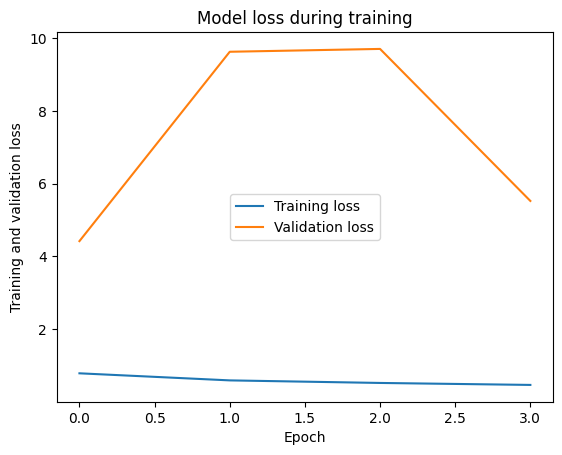

In [13]:
import matplotlib.pyplot as plt
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('Model loss during training')
plt.xlabel('Epoch')
plt.ylabel('Training and validation loss')
plt.legend(['Training loss', 'Validation loss']) # Ajout des crochets pour faire une liste

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29972\2460138713.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_29972\2460138713.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('Training accuracy ','Validation accuracy')


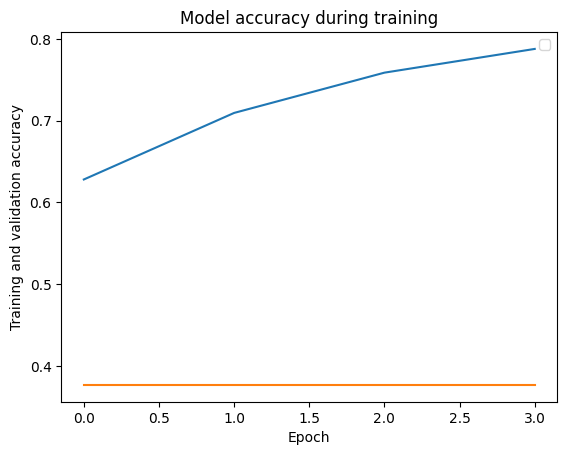

In [14]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('Model accuracy during training')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training and validation accuracy')
plt.legend('Training accuracy ','Validation accuracy')

In [15]:
loss, acc =classifier.evaluate(validation_set)  
print("Test Loss:", loss)
print("Test Accuracy:", acc)                  

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.3766 - loss: 5.5217
Test Loss: 5.52171516418457
Test Accuracy: 0.3766135275363922


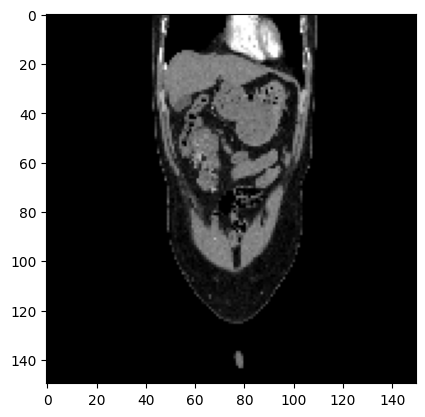

In [16]:
#Prediction sur nouvelle photo
import keras.utils as image
testing_image = image.load_img('dataset_CT_kidney/test/Tumor/Tumor- (2).jpg',
        target_size=(150,150))
plt.imshow(testing_image)
plt.show()

In [17]:
testing_image = image.img_to_array(testing_image)
testing_image = testing_image / 255.0 
testing_image = np.expand_dims(testing_image,axis=0)
result2 = classifier.predict(testing_image)
prob = result2[0][0]
prob_entier = round(prob)
if prob > 0.5:
    print("Classe prédite : TUMOR")
else:
    print("Classe prédite : STONE")

print("Probabilité :", prob_entier)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Classe prédite : STONE
Probabilité : 0


In [18]:
#Connaitre l attribution des classes par tensorflow
training_set.class_indices

{'Stone': 0, 'Tumor': 1}

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step


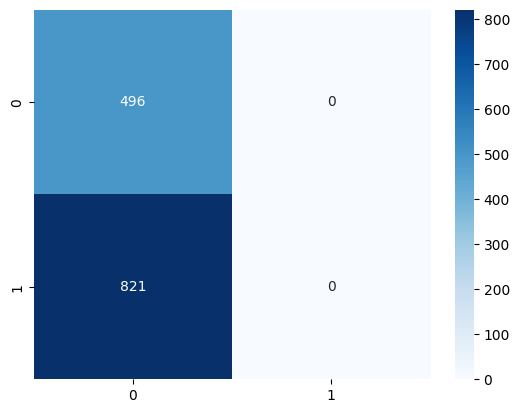

              precision    recall  f1-score   support

           0       0.38      1.00      0.55       496
           1       0.00      0.00      0.00       821

    accuracy                           0.38      1317
   macro avg       0.19      0.50      0.27      1317
weighted avg       0.14      0.38      0.21      1317



s:\venvs\.env_kidney\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\venvs\.env_kidney\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
s:\venvs\.env_kidney\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Prédictions
y_pred = classifier.predict(validation_set)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_true = validation_set.classes

# Matrice
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

print(classification_report(y_true, y_pred_classes))